# 00_SAR_intro

Let's take a quick look at some Sentinel-1 SAR data over our site of interest with NASA's OPERA CSLC products

In [30]:
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import box
import pandas as pd
import asf_search
import numpy as np

In [15]:
# read in the SNOTEL sites
gf_snotel = gpd.read_file(
    "https://github.com/egagli/snotel_ccss_stations/raw/main/all_stations.geojson"
    ).set_index("code")
gf_snotel = gf_snotel[gf_snotel.network == "SNOTEL"].reset_index()
sntl_codes = ['589_CO_SNTL', '1185_CO_SNTL', '465_CO_SNTL', 
              '586_CO_SNTL', '629_CO_SNTL', '713_CO_SNTL', '538_CO_SNTL']
gf_snotel_co_4326 = gf_snotel[gf_snotel.code.isin(sntl_codes)]
gf_snotel_co_utm = gf_snotel_co_4326.to_crs("EPSG:32612")

In [16]:
bounds = gf_snotel_co_4326.total_bounds
gf_search = gpd.GeoDataFrame(
    geometry=[box(bounds[0], bounds[1], bounds[2], bounds[3])],
    crs="EPSG:4326"
)

In [17]:
wkt_search = gf_search.geometry.to_wkt().iloc[0]
parms = {
        'dataset':asf_search.DATASET.OPERA_S1,
        'processingLevel':asf_search.PRODUCT_TYPE.CSLC,
        'intersectsWith':wkt_search,
        'operaBurstID':['T049_103322_IW2', 'T129_275785_IW1'],
        'start':'2018-01-01T00:00:00Z',
        'end':'2018-01-31T00:00:00Z',
        'flightDirection':asf_search.FLIGHT_DIRECTION.ASCENDING,
        'maxResults':100,
}

In [18]:
burst_hits = asf_search.search(**parms)

In [19]:
all_urls = [url for item in burst_hits for url in [item.properties['url']]]

In [ ]:
asf_search.download_urls(urls=all_urls, path='/home/jehayes/sh_final/cslc/asc')

In [22]:
fn_1 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180103T010924Z_20240428T014600Z_S1B_VV_v1.1.h5"
fn_2 = "/home/jehayes/sh_final/cslc/asc/OPERA_L2_CSLC-S1_T049-103322-IW2_20180115T010923Z_20240428T051456Z_S1B_VV_v1.1.h5"

In [23]:
dsR = xr.open_dataset(fn_1,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))

# start time of the SAR acquisition in UTC
tR = pd.to_datetime(xr.open_dataset(fn_1, 
                                    group='identification')['zero_doppler_start_time'].data.astype('U')) # Unicode string format
print(tR)
print(dsR)

2018-01-03 01:09:24.158212
<xarray.DataArray 'VV' (y: 4941, x: 20670)> Size: 817MB
[102130470 values with dtype=complex64]
Coordinates:
  * x        (x) float64 165kB 7.14e+05 7.14e+05 ... 8.173e+05 8.173e+05
  * y        (y) float64 40kB 4.218e+06 4.218e+06 ... 4.169e+06 4.169e+06
Attributes:
    description:   VV geocoded CSLC image
    grid_mapping:  projection


In [24]:
dsS = xr.open_dataset(fn_2,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))

tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))
print(tS)

2018-01-15 01:09:23.795973


In [ ]:
# Wrapped interferogram Calculation
# multiply dsR (reference image) by the complex conjugate of dsS (secondary image)
ifg = dsR * np.conj(dsS)
ifg.attrs['reference'] = tR
ifg.attrs['secondary'] = tS

In [26]:
da = xr.apply_ufunc(np.angle, ifg)
ds = da.to_dataset(name='phase')

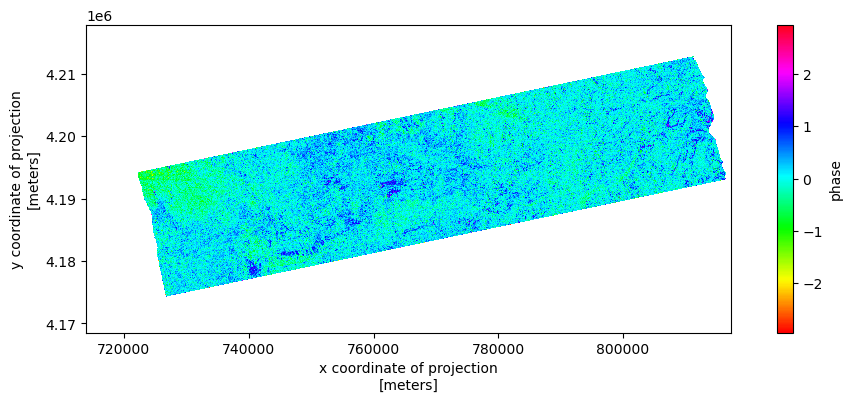

In [27]:
# 80meter posting for faster plots
# phase unwrapping and filtering still necessary
nx=16
ny=8 

fig,ax = plt.subplots(figsize=(12,4))
ds.phase.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=ax) #20m posting
plt.gca().set_aspect('equal')

In [28]:
# log scale the amplitude for viz purposes
def scale_amplitude(da):
    ''' decible scale for viz'''
    return 20*np.log10(np.abs(da))

ds['amplitude'] = xr.apply_ufunc(scale_amplitude, ifg)

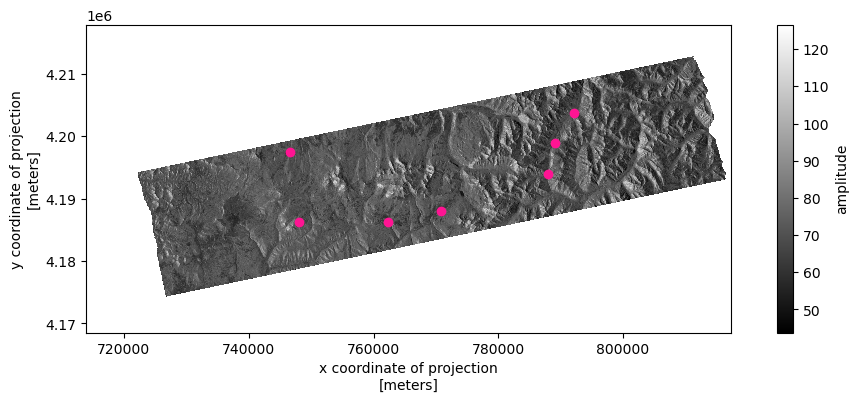

In [29]:
f, ax = plt.subplots(figsize=(12,4))
ds.amplitude.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='gray', ax=ax) #20m posting
gf_snotel_co_utm.plot(ax=ax, color="deeppink")
plt.gca().set_aspect('equal');